# ml lab11

### 1. Physical Unclonable Functions, PUF
Физически неклонируемые функции, ФНФ 

ФНФ - это аппаратные реализации хеш функций, которые позволяют проверить уникальность интегральной схемы

`R_i = PUF(CH_i)`, где `R` - это ответ ( _response_ ), а `CH` - запрос ( _challenge_ )

### 2. problem in terms of ml

В простейщем случае ФНФ это отображение из `CH` в `R`. Таким образом задача машинного обучения - предсказывать ответы на основе запросов.

Входные данные _challenge_ : `10001001` - бинарный вектор, ответ - `0` или `1`. Получается задача бинарной классификации.

### 3. train model for response predictions

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.neural_network
import sklearn.ensemble

#### puf simulator

In [2]:
MEAN = 0
STD = 1

class PUFSimulator:
    def __init__(self, f_size, set_size):
        self.size = f_size
        # mock hardware delays with normal distribution
        self.delays = np.random.normal(MEAN, STD, 2 * f_size)

        _sub = self.delays[:f_size] - self.delays[f_size:]
        _sum = self.delays[:f_size] + self.delays[f_size:]
        self.param = np.concatenate((_sub, np.array([0])), 0)
        self.param[1:] += _sum
        self.challenges = np.random.randint(0, 2, [f_size, set_size])
    
    def _get_featrue(self, i):
        return np.prod(1 - 2 * self.challenges[i:, :], 0)
    
    def get_features(self):
        features = [self._get_featrue(i) for i in range(self.size)]
        ones = np.ones((1, self.challenges.shape[1]))
        return np.concatenate((features, ones))
    
    def get_response(self, features):
        return np.sign(np.dot(self.param, features))

In [3]:
NUM_FEATURES = 32
SET_SIZE = 10000

puf = PUFSimulator(NUM_FEATURES, SET_SIZE)
X = puf.get_features()
y = puf.get_response(X)
X = X.T

X.shape

(10000, 33)

#### train helpers

In [4]:
def build_model(X, y, clf, silent=True):
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25)
    clf.fit(X_train, y_train)
    train_score, test_score = clf.score(X_train, y_train), clf.score(X_test, y_test)
    if not silent:
        print(f'> {type(clf).__name__}:')
        print(f'\tTrain:\t{train_score}\n\tTest:\t{test_score}')
    return train_score, test_score

In [5]:
def run_model(X, y, clf, sizes):
    train_scores = []
    test_scores = []
    for size in sizes:
        train_score, test_score = build_model(X[:size], y[:size], clf)
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(12, 6))
    plt.plot(sizes, train_scores, c='b', label='Train Score')
    plt.plot(sizes, test_scores, c='r', label='Test Score')
    plt.xlabel('Dataset Size')
    plt.ylabel('Accuracy')
    plt.title(type(clf).__name__)
    plt.legend()
    plt.show()
    
    return test_scores

#### `LogisticRegression`

In [6]:
get_lr = lambda: sklearn.linear_model.LogisticRegression(solver='liblinear')
build_model(X, y, get_lr(), silent=False);

> LogisticRegression:
	Train:	0.9965333333333334
	Test:	0.9956


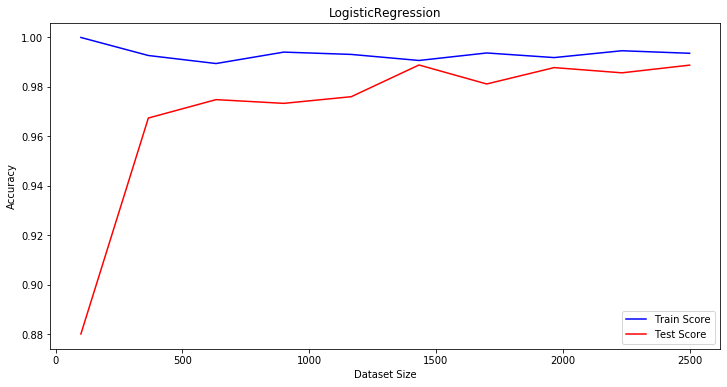

In [7]:
TEST_SIZES = np.linspace(100, 2500, 10, dtype=int)
lg_scores = run_model(X, y, get_lr(), TEST_SIZES)

> Из графика видно что точность растёт с ростом размера данных. При `1000+` достигается точность в `97%`

#### `SVM` - Support Vector Machine

In [8]:
get_svc = lambda: sklearn.svm.SVC(C=1, gamma='scale')
build_model(X, y, get_svc(), silent=False);

> SVC:
	Train:	0.9985333333333334
	Test:	0.97


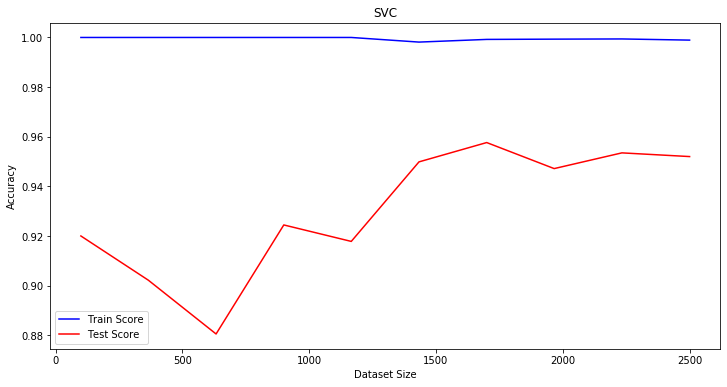

In [9]:
svc_scores = run_model(X, y, get_svc(), TEST_SIZES)

> Для метода опорных векторов получаем худщее качество на валидационной выборке. При `2000+` достигается точность в `95%`

 #### neural network `MLPClassifier`

In [10]:
get_nn = lambda: sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(NUM_FEATURES),
    alpha=1e-3,
    max_iter=1000
)

build_model(X, y, get_nn(), silent=False);

> MLPClassifier:
	Train:	1.0
	Test:	0.986


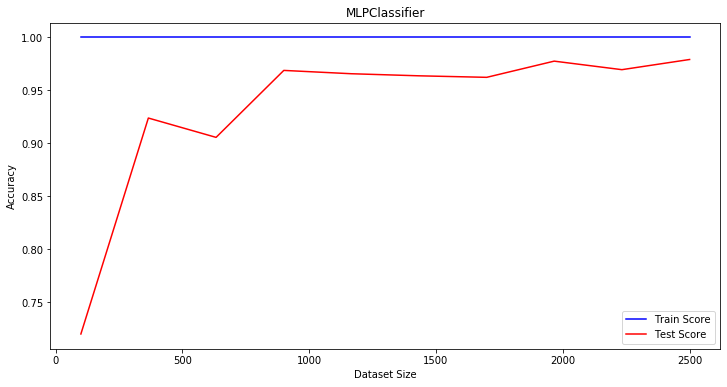

In [11]:
nn_scores = run_model(X, y, get_nn(), TEST_SIZES)

> Точность с нейронной сетью стремится к `99%`, При `1000+` достигается `95%`

#### `GradientBoostingClassifier`

In [12]:
get_gb = lambda: sklearn.ensemble.GradientBoostingClassifier(n_estimators=400, max_depth=3)

build_model(X, y, get_gb(), silent=False);

> GradientBoostingClassifier:
	Train:	0.9889333333333333
	Test:	0.9544


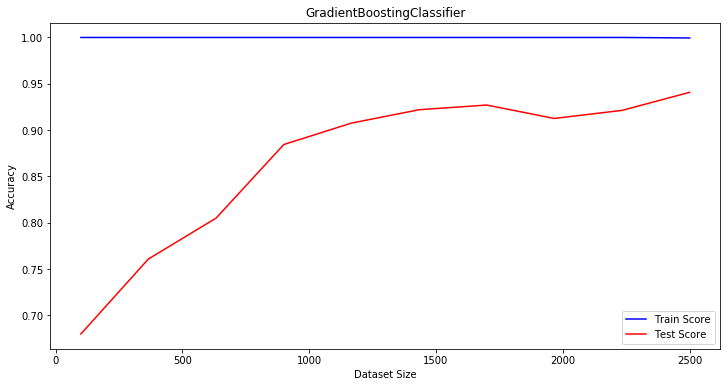

In [13]:
gb_scores = run_model(X, y, get_gb(), TEST_SIZES)

> Результат градиентного бустинга очень похож на полученный с помощью нейронной сети

#### all results on one plot

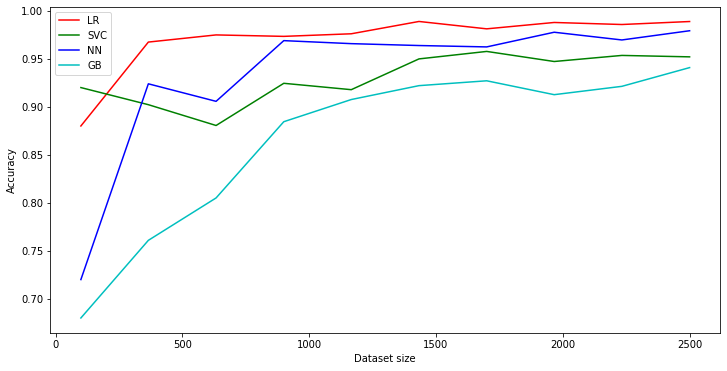

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(TEST_SIZES, lg_scores, c='r', label='LR')
plt.plot(TEST_SIZES, svc_scores, c='g', label='SVC')
plt.plot(TEST_SIZES, nn_scores, c='b', label='NN')
plt.plot(TEST_SIZES, gb_scores, c='c', label='GB')
plt.xlabel('Dataset size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> В сравнении лучше всего себя проявляет логистическая регрессия

#### test on real data

In [15]:
def read_data(size):
    filename = f'data/Base{size}.txt'
    raw_data = np.genfromtxt(filename, delimiter=' ', dtype=str)
    target = np.squeeze(raw_data[:, 1]).astype(int)
    data = [list(str) for str in raw_data[:, 0]]
    data = np.array(data, dtype=float)
    return data, target

In [16]:
base8_X, base8_y = read_data(8)

base8_X.shape

(1000000, 8)

In [17]:
def run_models(models, X, y, sizes):
    colors = cm.rainbow(np.linspace(0, 1, len(models)))
    models_scores = []
    
    for model in models:
        train_score, test_score = build_model(X, y, clf=model, silent=False)
        scores = run_model(X, y, model, sizes)
        models_scores.append(scores)

    plt.figure(figsize=(12, 6))
    for i, sc in enumerate(models_scores):
        plt.plot(sizes, sc, c=colors[i], label=type(models[i]).__name__)

    plt.xlabel('Dataset Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

> LogisticRegression:
	Train:	0.7361333333333333
	Test:	0.74


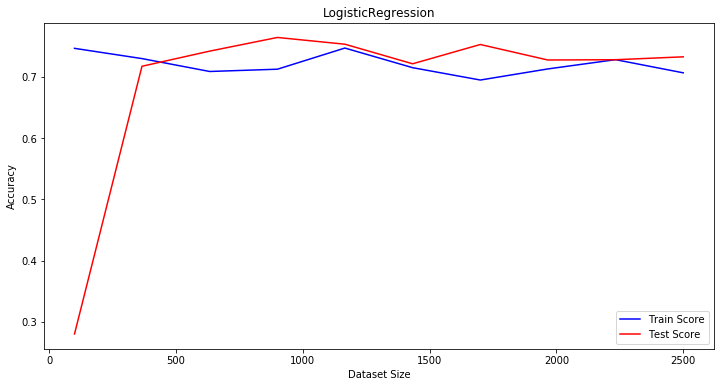

> SVC:
	Train:	1.0
	Test:	1.0


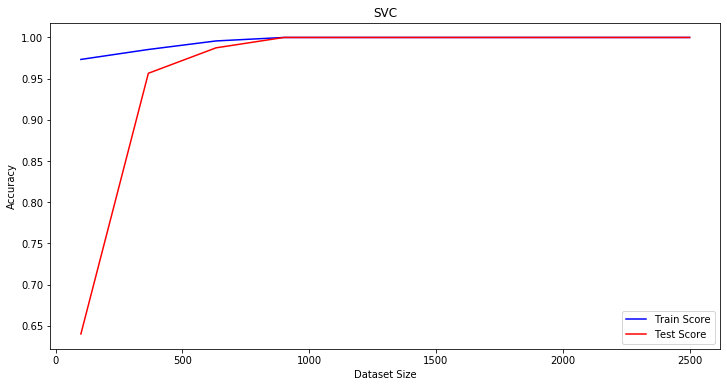

> MLPClassifier:
	Train:	1.0
	Test:	1.0


/Users/drapegnik/.pyenv/versions/3.7.4/envs/bsuir/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


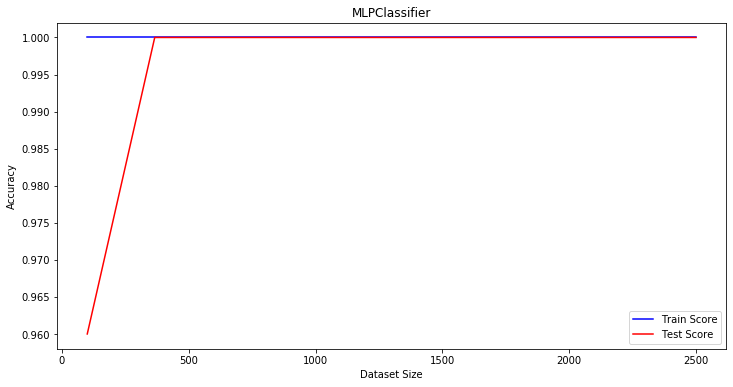

> GradientBoostingClassifier:
	Train:	1.0
	Test:	1.0


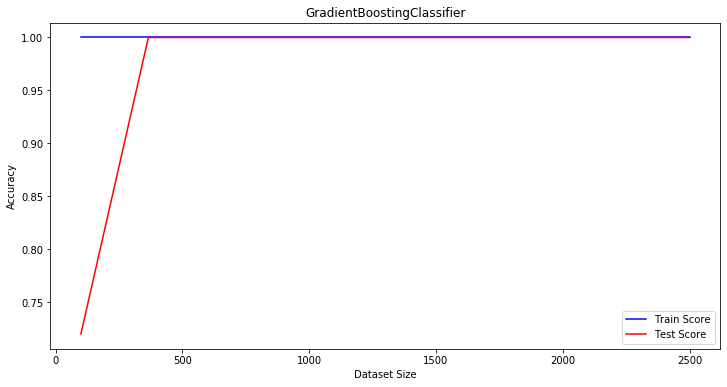

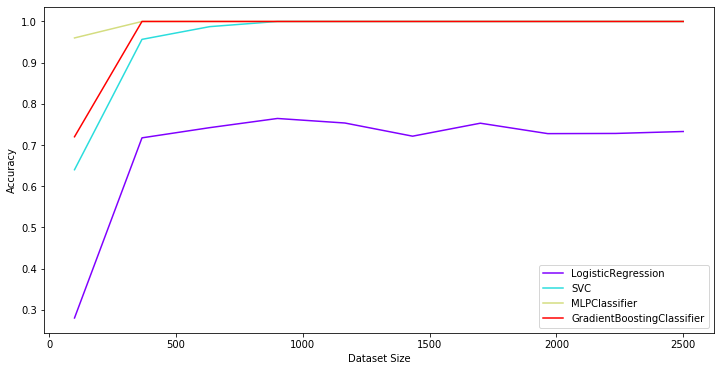

In [18]:
lr_clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
svc_clf = sklearn.svm.SVC(C=1, gamma='scale')
nn_clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(8, 8, 8), alpha=1e-3, max_iter=1000)
gb_clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=500, max_depth=3)

models = [lr_clf, svc_clf, nn_clf, gb_clf]
run_models(models, base8_X[:SET_SIZE], base8_y[:SET_SIZE], TEST_SIZES)

> для реальных данных `Base8` логистическая регрессия показывает себя хуже всего. Остальные 3 метода - одинаково хороши

#### `base16` test

In [21]:
base16_X, base16_y = read_data(16)

base16_X.shape

(1000000, 16)

> LogisticRegression:
	Train:	0.5996
	Test:	0.614


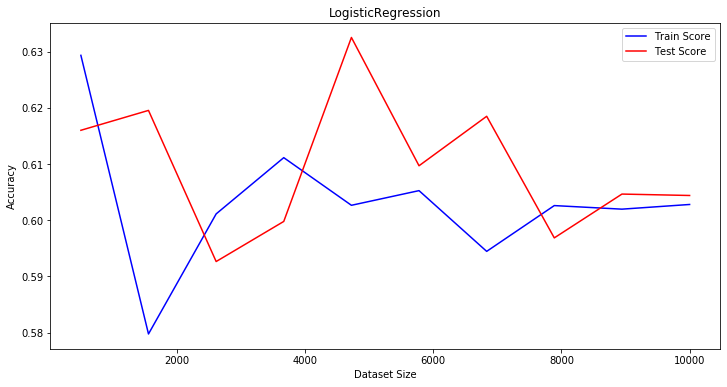

> SVC:
	Train:	0.7244
	Test:	0.7


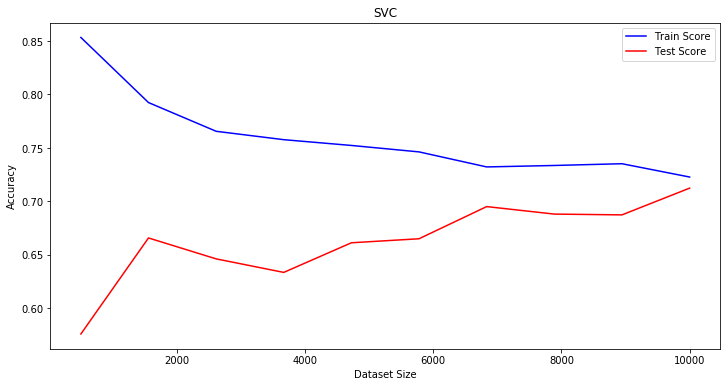

> MLPClassifier:
	Train:	0.9642666666666667
	Test:	0.8184


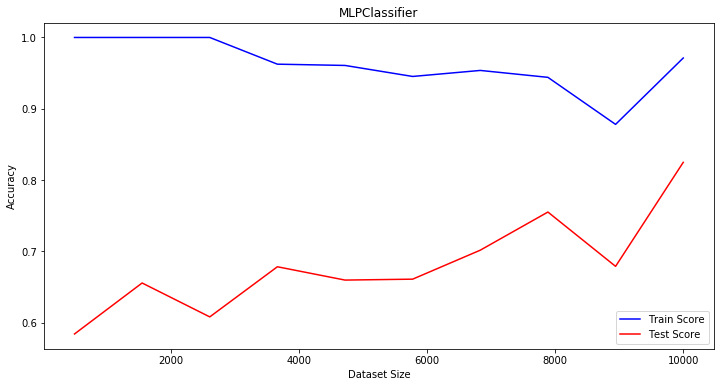

> GradientBoostingClassifier:
	Train:	0.7618666666666667
	Test:	0.6908


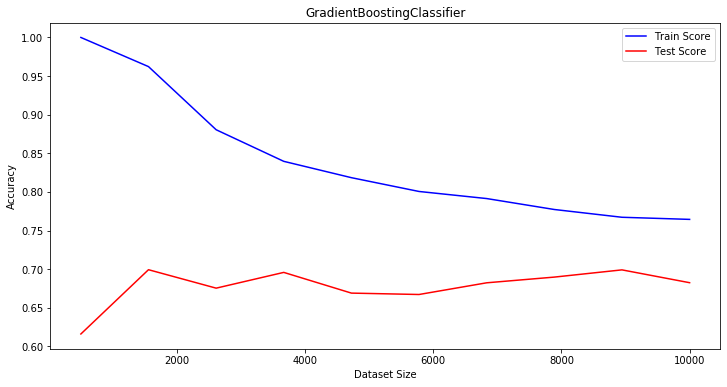

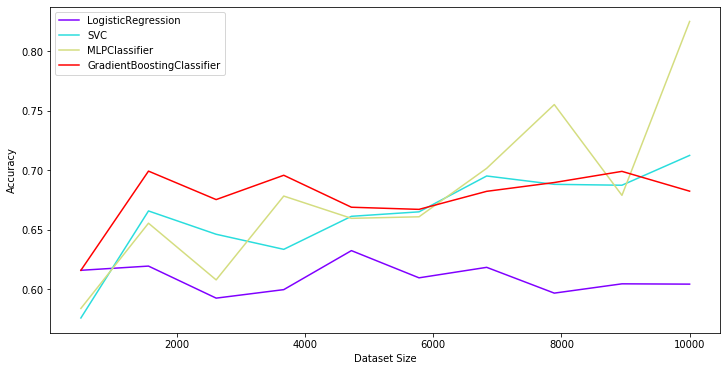

In [23]:
lr_clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
svc_clf = sklearn.svm.SVC(C=1, gamma='scale')
nn_clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32, 32, 32), alpha=1e-3, max_iter=10000)
gb_clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=600, max_depth=4)

models = [lr_clf, svc_clf, nn_clf, gb_clf]
run_models(models, base16_X[:SET_SIZE], base16_y[:SET_SIZE], sizes=np.linspace(500, 10000, 10, dtype=int))

> Для данных большей размерности результаты сразу ухудшаются, однако нейронная сеть достигает точности в `82%` на большой выборке (10000)

### 10. conclusions

Был рассмотрен метод криптоатаки на физически неклонируемые функции.

Использовались различные методы: логистическая регрессия, метод опорных векторов, нейронные сети и градиентный бустинг.

Для оценки качеста использовалась метрика точности классификации (`Accuracy`).

Для `Base8` удалось достичь `100%` точности, однако для уже `Base16` максимум был `82%` у нейронной сети.

Точность увеличивается с размером тестовой выборки.